# PREPROCESSING & FEATURE ENGINEERING - CHURN PREDICTION

### **Objectif** : Préparer les données pour la modélisation

### **Étapes** :
#### 1. Nettoyage des données
#### 2. Encodage des variables catégorielles
#### 3. Feature Engineering (création de nouvelles variables)
#### 4. Gestion du déséquilibre des classes
#### 5. Normalisation/Standardisation
#### 6. Split train/validation

## Importation des bibliothèques

In [9]:
# ## 1. IMPORTATION & CHARGEMENT

# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import warnings
warnings.filterwarnings('ignore')

In [65]:
## Gestion du déséquilibre
# Note: Désactivation temporaire de imbalanced-learn à cause de problèmes de compatibilité
# Utilisation de techniques alternatives manuelles
IMBLEARN_AVAILABLE = False
print(" Utilisation de techniques de rééquilibrage manuelles")
print(" (Alternative à imbalanced-learn pour éviter les conflits de versions)")

 Utilisation de techniques de rééquilibrage manuelles
 (Alternative à imbalanced-learn pour éviter les conflits de versions)


## Collecte de données

In [14]:

# Configuration
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("Bibliothèques importées avec succès!")


Bibliothèques importées avec succès!


In [16]:
# Chargement des données avec gestion robuste des chemins
from pathlib import Path

In [18]:
# Détecter le chemin de base
current_path = Path.cwd()
if current_path.name == 'notebooks':
    base_path = current_path.parent
else:
    base_path = current_path

data_path = base_path / 'data' / 'raw'

print(f" Chemin de base: {base_path}")
print(f" Dossier data: {data_path}")

# Charger les données
train_df = pd.read_csv(data_path / 'train.csv')
test_df = pd.read_csv(data_path / 'test.csv')

print(f" Train set: {train_df.shape}")
print(f" Test set:  {test_df.shape}")


 Chemin de base: C:\Users\Easy Services Pro\Projet_Machine_Learning2
 Dossier data: C:\Users\Easy Services Pro\Projet_Machine_Learning2\data\raw
 Train set: (165034, 14)
 Test set:  (110023, 13)


In [23]:
# Aperçu des données
print("\n Aperçu des données d'entraînement:")
display(train_df.head())

print("\n Informations sur les colonnes:")
display(train_df.info())


 Aperçu des données d'entraînement:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0



 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


None

## Traitement des données

In [25]:
### NETTOYAGE DES DONNÉES

def clean_data(df, is_train=True):
    """
    Nettoie le dataset
    
    Args:
        df: DataFrame à nettoyer
        is_train: True si train set, False si test set
    
    Returns:
        DataFrame nettoyé
    """
    df_clean = df.copy()
    
    print("="*60)
    print(" NETTOYAGE DES DONNÉES")
    print("="*60)
    
    # Identifier les colonnes à supprimer (ID, etc.)
    cols_to_drop = []
    
    if 'id' in df_clean.columns:
        cols_to_drop.append('id')
    if 'CustomerId' in df_clean.columns:
        cols_to_drop.append('CustomerId')
    if 'Surname' in df_clean.columns:
        cols_to_drop.append('Surname')
    
    if cols_to_drop:
        print(f"\n Suppression des colonnes inutiles: {cols_to_drop}")
        df_clean = df_clean.drop(columns=cols_to_drop)
    
    # Vérifier les valeurs manquantes
    missing = df_clean.isnull().sum()
    if missing.sum() > 0:
        print(f"\n Valeurs manquantes détectées:")
        for col, count in missing[missing > 0].items():
            print(f"   - {col}: {count} ({count/len(df_clean)*100:.2f}%)")
    else:
        print("\n Aucune valeur manquante")
    
    # Vérifier les doublons
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        print(f"\n {duplicates} lignes dupliquées détectées")
        response = "n"  # Ne pas supprimer automatiquement
        if response == "o":
            df_clean = df_clean.drop_duplicates()
            print(f" Doublons supprimés")
    else:
        print("\n Aucun doublon")
    
    print(f"\n Dimensions après nettoyage: {df_clean.shape}")
    
    return df_clean

In [27]:
# Nettoyer les données
train_clean = clean_data(train_df, is_train=True)
test_clean = clean_data(test_df, is_train=False)

 NETTOYAGE DES DONNÉES

 Suppression des colonnes inutiles: ['id', 'CustomerId', 'Surname']

 Aucune valeur manquante

 123 lignes dupliquées détectées

 Dimensions après nettoyage: (165034, 11)
 NETTOYAGE DES DONNÉES

 Suppression des colonnes inutiles: ['id', 'CustomerId', 'Surname']

 Aucune valeur manquante

 72 lignes dupliquées détectées

 Dimensions après nettoyage: (110023, 10)


In [29]:
# Sauvegarder les colonnes pour référence
if 'Exited' in train_clean.columns:
    feature_columns = [col for col in train_clean.columns if col != 'Exited']
    target_column = 'Exited'
    print(f"\n Variable cible: {target_column}")
    print(f" {len(feature_columns)} variables explicatives identifiées")


 Variable cible: Exited
 10 variables explicatives identifiées


In [31]:
### FEATURE ENGINEERING

def create_features(df):
    """
    Crée de nouvelles features pertinentes
    
    Args:
        df: DataFrame original
    
    Returns:
        DataFrame avec nouvelles features
    """
    df_new = df.copy()
    
    print("="*60)
    print("FEATURE ENGINEERING")
    print("="*60)
    
    # 1. Ratio Balance/Salary
    if 'Balance' in df_new.columns and 'EstimatedSalary' in df_new.columns:
        df_new['BalanceSalaryRatio'] = df_new['Balance'] / (df_new['EstimatedSalary'] + 1)
        print("BalanceSalaryRatio créé")
    
    # 2. Age groups
    if 'Age' in df_new.columns:
        df_new['AgeGroup'] = pd.cut(df_new['Age'], 
                                     bins=[0, 30, 40, 50, 100],
                                     labels=['Young', 'Adult', 'Middle', 'Senior'])
        print("AgeGroup créé")
    
    # 3. Tenure groups
    if 'Tenure' in df_new.columns:
        df_new['TenureGroup'] = pd.cut(df_new['Tenure'],
                                       bins=[-1, 2, 5, 10],
                                       labels=['New', 'Regular', 'Loyal'])
        print("TenureGroup créé")
    
    # 4. Credit Score groups
    if 'CreditScore' in df_new.columns:
        df_new['CreditScoreGroup'] = pd.cut(df_new['CreditScore'],
                                            bins=[0, 600, 700, 850],
                                            labels=['Poor', 'Good', 'Excellent'])
        print("CreditScoreGroup créé")
    
    # 5. Is Zero Balance (clients sans argent)
    if 'Balance' in df_new.columns:
        df_new['IsZeroBalance'] = (df_new['Balance'] == 0).astype(int)
        print(" IsZeroBalance créé")
    
    # 6. Product Diversity (a plusieurs produits)
    if 'NumOfProducts' in df_new.columns:
        df_new['HasMultipleProducts'] = (df_new['NumOfProducts'] > 1).astype(int)
        print(" HasMultipleProducts créé")
    
    # 7. Engagement Score (combinaison de plusieurs features)
    if all(col in df_new.columns for col in ['IsActiveMember', 'HasCrCard', 'NumOfProducts']):
        df_new['EngagementScore'] = (
            df_new['IsActiveMember'] + 
            df_new['HasCrCard'] + 
            (df_new['NumOfProducts'] / 4)
        )
        print(" EngagementScore créé")
    
    # 8. Age x Balance (interaction)
    if 'Age' in df_new.columns and 'Balance' in df_new.columns:
        df_new['Age_Balance_Interaction'] = df_new['Age'] * df_new['Balance'] / 100000
        print(" Age_Balance_Interaction créé")
    
    # 9. Tenure per Age (fidélité relative)
    if 'Tenure' in df_new.columns and 'Age' in df_new.columns:
        df_new['TenureAgeRatio'] = df_new['Tenure'] / df_new['Age']
        print(" TenureAgeRatio créé")
    
    print(f"\n Nombre de features après engineering: {df_new.shape[1]}")
    
    return df_new

In [33]:
# Créer les nouvelles features
train_engineered = create_features(train_clean)
test_engineered = create_features(test_clean)

FEATURE ENGINEERING
BalanceSalaryRatio créé
AgeGroup créé
TenureGroup créé
CreditScoreGroup créé
 IsZeroBalance créé
 HasMultipleProducts créé
 EngagementScore créé
 Age_Balance_Interaction créé
 TenureAgeRatio créé

 Nombre de features après engineering: 20
FEATURE ENGINEERING
BalanceSalaryRatio créé
AgeGroup créé
TenureGroup créé
CreditScoreGroup créé
 IsZeroBalance créé
 HasMultipleProducts créé
 EngagementScore créé
 Age_Balance_Interaction créé
 TenureAgeRatio créé

 Nombre de features après engineering: 19


In [35]:
# Visualiser quelques nouvelles features
new_features = ['BalanceSalaryRatio', 'IsZeroBalance', 'HasMultipleProducts', 'EngagementScore']

print("\n Aperçu des nouvelles features:\n")
display(train_engineered[new_features].head(10))

print("\n Statistiques des nouvelles features:\n")
display(train_engineered[new_features].describe())


 Aperçu des nouvelles features:



,BalanceSalaryRatio,IsZeroBalance,HasMultipleProducts,EngagementScore
0,0.000000,1,1,1.50
1,0.000000,1,1,2.50
2,0.000000,1,1,1.50
3,1.760634,0,0,2.25
4,0.000000,1,1,2.50
5,0.968780,0,0,1.25
6,4.859267,0,0,1.25
7,1.295957,0,0,1.25
8,0.000000,1,1,1.50
9,0.475722,0,0,2.25



 Statistiques des nouvelles features:



,BalanceSalaryRatio,IsZeroBalance,HasMultipleProducts,EngagementScore
count,165034.000000,165034.000000,165034.000000,165034.000000
mean,2.040911,0.543209,0.531163,1.640338
std,84.494114,0.498131,0.499029,0.671743
min,0.000000,0.000000,0.000000,0.250000
25%,0.000000,0.000000,0.000000,1.250000
50%,0.000000,1.000000,1.000000,1.500000
75%,0.978809,1.000000,1.000000,2.250000
max,11841.236884,1.000000,1.000000,3.000000


In [37]:
# Analyser l'impact des nouvelles features sur le churn
if 'Exited' in train_engineered.columns:
    print("\n IMPACT DES NOUVELLES FEATURES SUR LE CHURN\n")
    
    for feature in new_features:
        if feature in train_engineered.columns:
            print(f"\n {feature}:")
            
            # Moyenne par groupe
            churn_mean = train_engineered.groupby('Exited')[feature].mean()
            print(f"   Moyenne Restés (0): {churn_mean[0]:.4f}")
            print(f"   Moyenne Partis (1): {churn_mean[1]:.4f}")
            
            # Test statistique
            from scipy import stats
            group_0 = train_engineered[train_engineered['Exited'] == 0][feature].dropna()
            group_1 = train_engineered[train_engineered['Exited'] == 1][feature].dropna()
            t_stat, p_value = stats.ttest_ind(group_0, group_1)
            
            print(f"   P-value: {p_value:.6f}", end="")
            if p_value < 0.001:
                print(" *** (Très significatif)")
            elif p_value < 0.01:
                print(" ** (Significatif)")
            elif p_value < 0.05:
                print(" * (Légèrement significatif)")
            else:
                print(" (Non significatif)")


 IMPACT DES NOUVELLES FEATURES SUR LE CHURN


 BalanceSalaryRatio:
   Moyenne Restés (0): 1.9655
   Moyenne Partis (1): 2.3218
   P-value: 0.484166 (Non significatif)

 IsZeroBalance:
   Moyenne Restés (0): 0.5776
   Moyenne Partis (1): 0.4150
   P-value: 0.000000 *** (Très significatif)

 HasMultipleProducts:
   Moyenne Restés (0): 0.6118
   Moyenne Partis (1): 0.2309
   P-value: 0.000000 *** (Très significatif)

 EngagementScore:
   Moyenne Restés (0): 1.7149
   Moyenne Partis (1): 1.3624
   P-value: 0.000000 *** (Très significatif)


In [39]:
### ENCODAGE DES VARIABLES CATÉGORIELLES

def encode_categorical_features(train_df, test_df, target_col='Exited'):
    """
    Encode les variables catégorielles
    
    Args:
        train_df: DataFrame d'entraînement
        test_df: DataFrame de test
        target_col: Nom de la colonne cible
    
    Returns:
        train_encoded, test_encoded, encoders
    """
    print("="*60)
    print(" ENCODAGE DES VARIABLES CATÉGORIELLES")
    print("="*60)
    
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    encoders = {}
    
    # Identifier les colonnes catégorielles
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\n Variables catégorielles détectées: {len(categorical_cols)}")
    for col in categorical_cols:
        print(f"   - {col}: {train_df[col].nunique()} valeurs uniques")
    
    # Encodage
    for col in categorical_cols:
        print(f"\n Encodage de '{col}'...")
        
        unique_values = train_df[col].nunique()
        
        # Label Encoding pour variables binaires
        if unique_values == 2:
            print(f"   → Label Encoding (binaire)")
            le = LabelEncoder()
            train_encoded[col] = le.fit_transform(train_df[col])
            test_encoded[col] = le.transform(test_df[col])
            encoders[col] = ('label', le)
        
        # One-Hot Encoding pour variables avec peu de catégories
        elif unique_values <= 10:
            print(f"   → One-Hot Encoding ({unique_values} catégories)")
            
            # Créer des dummy variables
            train_dummies = pd.get_dummies(train_df[col], prefix=col, drop_first=True)
            test_dummies = pd.get_dummies(test_df[col], prefix=col, drop_first=True)
            
            # S'assurer que train et test ont les mêmes colonnes
            missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
            for c in missing_cols:
                test_dummies[c] = 0
            
            extra_cols = set(test_dummies.columns) - set(train_dummies.columns)
            for c in extra_cols:
                test_dummies = test_dummies.drop(columns=[c])
            
            # Réordonner les colonnes
            test_dummies = test_dummies[train_dummies.columns]
            
            # Ajouter au DataFrame
            train_encoded = pd.concat([train_encoded, train_dummies], axis=1)
            test_encoded = pd.concat([test_encoded, test_dummies], axis=1)
            
            # Supprimer la colonne originale
            train_encoded = train_encoded.drop(columns=[col])
            test_encoded = test_encoded.drop(columns=[col])
            
            encoders[col] = ('onehot', train_dummies.columns.tolist())
            
            print(f" {len(train_dummies.columns)} nouvelles colonnes créées")
        
        else:
            print(f" Trop de catégories ({unique_values}) - Label Encoding appliqué")
            le = LabelEncoder()
            train_encoded[col] = le.fit_transform(train_df[col])
            test_encoded[col] = le.transform(test_df[col])
            encoders[col] = ('label', le)
    
    print(f"\n Encodage terminé!")
    print(f" Dimensions après encodage:")
    print(f"   Train: {train_encoded.shape}")
    print(f"   Test:  {test_encoded.shape}")
    
    return train_encoded, test_encoded, encoders

In [43]:
# Encoder les variables
train_encoded, test_encoded, encoders = encode_categorical_features(
    train_engineered, 
    test_engineered,
    target_col='Exited'
)

 ENCODAGE DES VARIABLES CATÉGORIELLES

 Variables catégorielles détectées: 5
   - Geography: 3 valeurs uniques
   - Gender: 2 valeurs uniques
   - AgeGroup: 4 valeurs uniques
   - TenureGroup: 3 valeurs uniques
   - CreditScoreGroup: 3 valeurs uniques

 Encodage de 'Geography'...
   → One-Hot Encoding (3 catégories)
 2 nouvelles colonnes créées

 Encodage de 'Gender'...
   → Label Encoding (binaire)

 Encodage de 'AgeGroup'...
   → One-Hot Encoding (4 catégories)
 3 nouvelles colonnes créées

 Encodage de 'TenureGroup'...
   → One-Hot Encoding (3 catégories)
 2 nouvelles colonnes créées

 Encodage de 'CreditScoreGroup'...
   → One-Hot Encoding (3 catégories)
 2 nouvelles colonnes créées

 Encodage terminé!
 Dimensions après encodage:
   Train: (165034, 25)
   Test:  (110023, 24)


In [45]:
# Aperçu des données encodées
print("\n Aperçu des données encodées:")
display(train_encoded.head())

print(f"\n Nombre total de features: {train_encoded.shape[1]}")


 Aperçu des données encodées:


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,IsZeroBalance,HasMultipleProducts,EngagementScore,Age_Balance_Interaction,TenureAgeRatio,Geography_Germany,Geography_Spain,AgeGroup_Adult,AgeGroup_Middle,AgeGroup_Senior,TenureGroup_Regular,TenureGroup_Loyal,CreditScoreGroup_Good,CreditScoreGroup_Excellent
0,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.000000,1,1,1.50,0.000000,0.090909,False,False,True,False,False,True,False,True,False
1,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.000000,1,1,2.50,0.000000,0.030303,False,False,True,False,False,False,False,True,False
2,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.000000,1,1,1.50,0.000000,0.250000,False,False,True,False,False,False,True,True,False
3,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.760634,0,0,2.25,50.620064,0.058824,False,False,True,False,False,False,False,False,False
4,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.000000,1,1,2.50,0.000000,0.151515,False,True,True,False,False,True,False,False,True



 Nombre total de features: 25


In [124]:
### GESTION DU DÉSÉQUILIBRE DES CLASSES

# Séparer X et y
if 'Exited' in train_encoded.columns:
    X = train_encoded.drop(columns=['Exited'])
    y = train_encoded['Exited']
    
    print("="*60)
    print("ANALYSE DU DÉSÉQUILIBRE")
    print("="*60)
    
    # Distribution actuelle
    churn_counts = y.value_counts()
    churn_pct = (churn_counts / len(y)) * 100
    
    print(f"\n Distribution actuelle:")
    print(f"   Classe 0 (Restés): {churn_counts[0]:,} ({churn_pct[0]:.2f}%)")
    print(f"   Classe 1 (Partis): {churn_counts[1]:,} ({churn_pct[1]:.2f}%)")
    
    imbalance_ratio = churn_counts[0] / churn_counts[1]
    print(f"\n Ratio de déséquilibre: 1:{imbalance_ratio:.2f}")
    
    if imbalance_ratio > 3:
        print("Dataset fortement déséquilibré - Utilisation de SMOTE recommandée")
    elif imbalance_ratio > 1.5:
        print("Dataset modérément déséquilibré")
    else:
        print("Dataset relativement équilibré")

ANALYSE DU DÉSÉQUILIBRE

 Distribution actuelle:
   Classe 0 (Restés): 130,113 (78.84%)
   Classe 1 (Partis): 34,921 (21.16%)

 Ratio de déséquilibre: 1:3.73
Dataset fortement déséquilibré - Utilisation de SMOTE recommandée


In [126]:
# Implémentation manuelle de SMOTE et autres techniques
class ManualSMOTE:
    """Implémentation simplifiée de SMOTE"""
    def __init__(self, k_neighbors=5, random_state=42):
        self.k_neighbors = k_neighbors
        self.random_state = random_state
        np.random.seed(random_state)
    
    def fit_resample(self, X, y):
        from sklearn.neighbors import NearestNeighbors
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        
        class_counts = y.value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()
        
        n_to_generate = class_counts[majority_class] - class_counts[minority_class]
        
        print(f"   Classe minoritaire ({minority_class}): {class_counts[minority_class]} échantillons")
        print(f"   Génération de {n_to_generate} échantillons synthétiques...")
        
        X_minority = X[y == minority_class].values
        nn = NearestNeighbors(n_neighbors=self.k_neighbors + 1)
        nn.fit(X_minority)
        
        synthetic_samples = []
        for _ in range(n_to_generate):
            idx = np.random.randint(0, len(X_minority))
            sample = X_minority[idx]
            neighbors_indices = nn.kneighbors([sample], return_distance=False)[0][1:]
            neighbor_idx = np.random.choice(neighbors_indices)
            neighbor = X_minority[neighbor_idx]
            alpha = np.random.random()
            synthetic_sample = sample + alpha * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)
        
        synthetic_samples = np.array(synthetic_samples)
        X_synthetic = pd.DataFrame(synthetic_samples, columns=X.columns)
        y_synthetic = pd.Series([minority_class] * len(synthetic_samples))
        
        X_resampled = pd.concat([X, X_synthetic], ignore_index=True)
        y_resampled = pd.concat([y, y_synthetic], ignore_index=True)
        
        return X_resampled, y_resampled

In [132]:
# Créer plusieurs versions du dataset avec différentes techniques
def create_balanced_datasets(X, y, random_state=42):
    """Crée plusieurs versions du dataset avec différentes techniques de rééquilibrage"""
    datasets = {}
    
    print("="*60)
    print("CRÉATION DES DATASETS RÉÉQUILIBRÉS")
    print("="*60)
    
    # 1. Original
    datasets['original'] = (X.copy(), y.copy())
    print(f"\n Original: {X.shape}")
    print(f"   Distribution: {y.value_counts().to_dict()}")
    
    # 2. SMOTE manuel
    print("\n Application de SMOTE (implémentation manuelle)...")
    try:
        smote = ManualSMOTE(k_neighbors=5, random_state=random_state)
        X_smote, y_smote = smote.fit_resample(X, y)
        datasets['smote'] = (X_smote, y_smote)
        print(f" SMOTE: {X_smote.shape}")
        print(f"   Distribution: {y_smote.value_counts().to_dict()}")
    except Exception as e:
        print(f" Erreur SMOTE: {str(e)}")
    
    # 3. Random Over-sampling
    print("\n Application de Random Over-sampling...")
    minority_class = y.value_counts().idxmin()
    majority_class = y.value_counts().idxmax()
    
    X_minority = X[y == minority_class]
    y_minority = y[y == minority_class]
    X_majority = X[y == majority_class]
    y_majority = y[y == majority_class]
    
    n_to_sample = len(y_majority) - len(y_minority)
    indices = np.random.choice(X_minority.index, size=n_to_sample, replace=True)
    X_minority_upsampled = X_minority.loc[indices]
    y_minority_upsampled = y_minority.loc[indices]
    
    X_oversampled = pd.concat([X_majority, X_minority, X_minority_upsampled], ignore_index=True)
    y_oversampled = pd.concat([y_majority, y_minority, y_minority_upsampled], ignore_index=True)
    
    datasets['oversampling'] = (X_oversampled, y_oversampled)
    print(f" Over-sampling: {X_oversampled.shape}")
    print(f"   Distribution: {y_oversampled.value_counts().to_dict()}")
    
    # 4. Random Under-sampling
    print("\n Application de Random Under-sampling...")
    n_minority = len(y_minority)
    indices_majority = np.random.choice(X_majority.index, size=n_minority, replace=False)
    X_majority_downsampled = X_majority.loc[indices_majority]
    y_majority_downsampled = y_majority.loc[indices_majority]
    
    X_undersampled = pd.concat([X_majority_downsampled, X_minority], ignore_index=True)
    y_undersampled = pd.concat([y_majority_downsampled, y_minority], ignore_index=True)
    
    datasets['undersampling'] = (X_undersampled, y_undersampled)
    print(f" Under-sampling: {X_undersampled.shape}")
    print(f" Distribution: {y_undersampled.value_counts().to_dict()}")
    
    return datasets

In [130]:
# Créer les datasets
balanced_datasets = create_balanced_datasets(X, y)
balanced_datasets

CRÉATION DES DATASETS RÉÉQUILIBRÉS

 Original: (165034, 24)
   Distribution: {0: 130113, 1: 34921}

 Application de SMOTE (implémentation manuelle)...
   Classe minoritaire (1): 34921 échantillons
   Génération de 95192 échantillons synthétiques...
 SMOTE: (260226, 24)
   Distribution: {0: 130113, 1: 130113}

 Application de Random Over-sampling...
 Over-sampling: (260226, 24)
   Distribution: {0: 130113, 1: 130113}

 Application de Random Under-sampling...
 Under-sampling: (69842, 24)
 Distribution: {0: 34921, 1: 34921}

 Application de SMOTETomek...


AttributeError: 'SMOTETomek' object has no attribute '_validate_data'

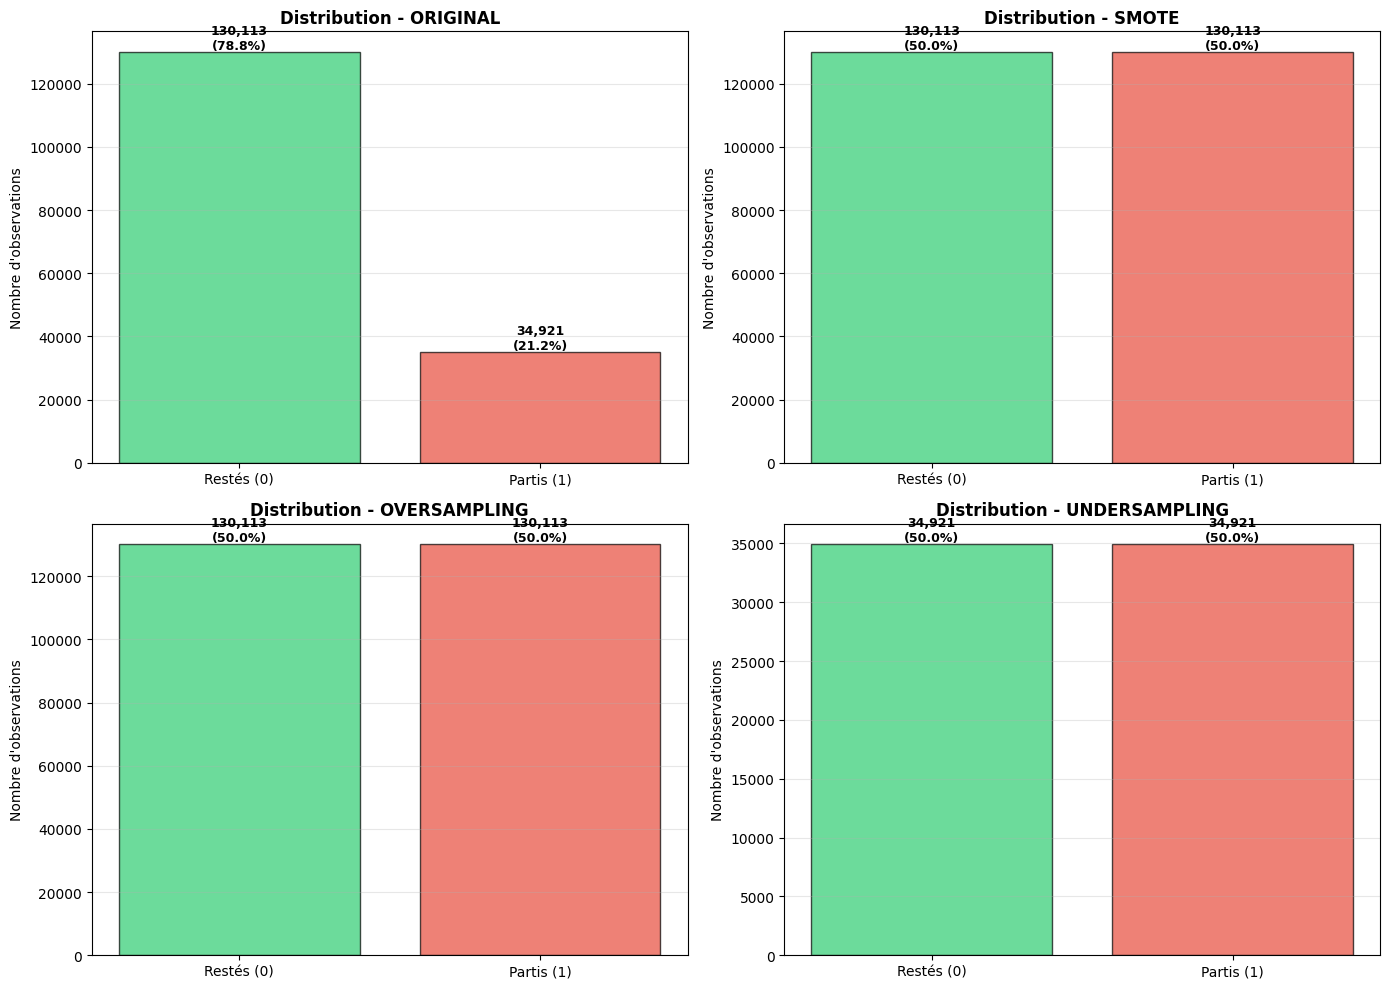

In [81]:
# Visualiser les différentes distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, (X_data, y_data)) in enumerate(balanced_datasets.items()):
    ax = axes[idx]
    
    counts = pd.Series(y_data).value_counts()
    colors = ['#2ecc71', '#e74c3c']
    
    bars = ax.bar(['Restés (0)', 'Partis (1)'], counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribution - {name.upper()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Nombre d\'observations')
    ax.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs
    for bar, count in zip(bars, counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({count/len(y_data)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### NORMALISATION / STANDARDISATION

In [83]:
def scale_features(X_train, X_test, method='standard'):
    """
    Normalise/Standardise les features
    
    Args:
        X_train: Features d'entraînement
        X_test: Features de test
        method: 'standard' ou 'robust'
    
    Returns:
        X_train_scaled, X_test_scaled, scaler
    """
    print(f"\n Scaling des features (méthode: {method})...")
    
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("method doit être 'standard' ou 'robust'")
    
    # Fit sur train, transform sur train et test
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reconvertir en DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print(f" Scaling terminé!")
    
    return X_train_scaled, X_test_scaled, scaler

In [85]:
# Choisir le dataset à utiliser (SMOTE par défaut)
X_final, y_final = balanced_datasets['smote']

print("\n Dataset sélectionné: SMOTE")
print(f"   Shape: {X_final.shape}")
print(f"   Distribution: {pd.Series(y_final).value_counts().to_dict()}")

# %%
# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y_final, 
    test_size=0.2, 
    random_state=42,
    stratify=y_final
)

print("="*60)
print("SPLIT TRAIN / VALIDATION")
print("="*60)
print(f"\n Train set: {X_train.shape}")
print(f" Validation set: {X_val.shape}")

print(f"\n Distribution Train:")
print(pd.Series(y_train).value_counts())

print(f"\n Distribution Validation:")
print(pd.Series(y_val).value_counts())


 Dataset sélectionné: SMOTE
   Shape: (260226, 24)
   Distribution: {0: 130113, 1: 130113}
SPLIT TRAIN / VALIDATION

 Train set: (208180, 24)
 Validation set: (52046, 24)

 Distribution Train:
1    104090
0    104090
Name: count, dtype: int64

 Distribution Validation:
0    26023
1    26023
Name: count, dtype: int64


In [87]:
# Scaler les données
X_train_scaled, X_val_scaled, scaler = scale_features(X_train, X_val, method='standard')

# Scaler aussi le test set
X_test_scaled = test_encoded.copy()
if 'Exited' in X_test_scaled.columns:
    X_test_scaled = X_test_scaled.drop(columns=['Exited'])

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_scaled),
    columns=X_test_scaled.columns,
    index=X_test_scaled.index
)

print(f"\n Scaling appliqué sur train, validation et test")


 Scaling des features (méthode: standard)...
 Scaling terminé!

 Scaling appliqué sur train, validation et test


### SAUVEGARDE DES DONNÉES PRÉPROCESSÉES

In [91]:
# Sauvegarder les données préprocessées
import joblib

print("="*60)
print("SAUVEGARDE DES DONNÉES")
print("="*60)

SAUVEGARDE DES DONNÉES


In [105]:
# Sauvegarder les datasets
X_train_scaled.to_csv('../data/processed/X_train.csv', index=False)
X_val_scaled.to_csv('../data/processed/X_val.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test.csv', index=False)

pd.Series(y_train).to_csv('../data/processed/y_train.csv', index=False, header=['Exited'])
pd.Series(y_val).to_csv('../data/processed/y_val.csv', index=False, header=['Exited'])

print("Datasets sauvegardés dans data/processed/")

Datasets sauvegardés dans data/processed/


In [109]:
# Sauvegarder le scaler et les encoders
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(encoders, '../models/encoders.pkl')

print("Scaler et encoders sauvegardés dans models/")

Scaler et encoders sauvegardés dans models/


In [119]:
# Sauvegarder aussi les versions non-scalées pour référence
joblib.dump({
    'original': balanced_datasets['original'],
    'smote': balanced_datasets['smote'],
    'undersampling': balanced_datasets['undersampling'],
    'smotetomek': balanced_datasets['oversampling']
}, '../data/processed/balanced_datasets.pkl')

print("Tous les datasets balancés sauvegardés")

Tous les datasets balancés sauvegardés


### RÉSUMÉ DU PREPROCESSING

In [122]:
print("="*80)
print("RÉSUMÉ DU PREPROCESSING")
print("="*80)

print(f"""
DIMENSIONS FINALES:
   Features d'entraînement:  {X_train_scaled.shape}
   Features de validation:   {X_val_scaled.shape}
   Features de test:         {X_test_scaled.shape}

FEATURES CRÉÉES:
   Features originales:      {len([col for col in train_clean.columns if col != 'Exited'])}
   Features engineered:      {train_engineered.shape[1] - train_clean.shape[1]}
   Features après encoding:  {X_final.shape[1]}

RÉÉQUILIBRAGE:
   Méthode utilisée:        SMOTE
   Distribution finale:     50% / 50%

SCALING:
   Méthode:                 StandardScaler
   Appliqué sur:            Train, Validation, Test

FICHIERS SAUVEGARDÉS:
   data/processed/X_train.csv
   data/processed/X_val.csv
   data/processed/X_test.csv
   data/processed/y_train.csv
   data/processed/y_val.csv
   models/scaler.pkl
   models/encoders.pkl
   data/processed/balanced_datasets.pkl

PROCHAINE ÉTAPE:
   → Modélisation (churn_03_modelisation.ipynb)
""")

print("="*80)
print("PREPROCESSING TERMINÉ AVEC SUCCÈS!")
print("="*80)

RÉSUMÉ DU PREPROCESSING

DIMENSIONS FINALES:
   Features d'entraînement:  (208180, 24)
   Features de validation:   (52046, 24)
   Features de test:         (110023, 24)

FEATURES CRÉÉES:
   Features originales:      10
   Features engineered:      9
   Features après encoding:  24

RÉÉQUILIBRAGE:
   Méthode utilisée:        SMOTE
   Distribution finale:     50% / 50%

SCALING:
   Méthode:                 StandardScaler
   Appliqué sur:            Train, Validation, Test

FICHIERS SAUVEGARDÉS:
   data/processed/X_train.csv
   data/processed/X_val.csv
   data/processed/X_test.csv
   data/processed/y_train.csv
   data/processed/y_val.csv
   models/scaler.pkl
   models/encoders.pkl
   data/processed/balanced_datasets.pkl

PROCHAINE ÉTAPE:
   → Modélisation (churn_03_modelisation.ipynb)

PREPROCESSING TERMINÉ AVEC SUCCÈS!
